 # Spatial Autocorreraltion of Racial Demographics in LA County

**Climate Group** 
 
In this notebook we analyze the spatial autocorrelation of race across Los Angeles County. We use spatial autocorrelation on our racial demographic data to  identify whether similar racial groups tend to cluster together geographically. If there's a high level of spatial autocorrelation, it suggests that neighboring areas share similar racial characteristics. Assesing the spatial patterns of race can help target interventions where they are most needed in relation to our heat data. 

Author of notebook: Pa-Shun Hawkins

In [1]:
# Importing all libraries
import pandas as pd
from sodapy import Socrata
import geopandas as gpd
import contextily as ctx
import esda
from esda.moran import Moran, Moran_Local
import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation
import libpysal as lps
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
df = pd.read_csv(
    'Data/la_demographincs.csv',  #reading in the file
    dtype=
    {
        'Geo_FIPS':str,
        'Geo_STATE':str, 
        'Geo_COUNTY':str    # calling the columns and chaning their dtype to bring back leading zero
    }
)
columns_to_keep = ['Geo_FIPS',   # seperating the columns to keep (race, FIPS, and county)
                   'Geo_COUNTY', 
                   'SE_T004_019',
                   'SE_T004_003',
                   'SE_T004_005',   
                   'SE_T004_007',
                   'SE_T004_009',
                   'SE_T004_011',
                   'SE_T004_017']
# add it to a new dataframe
df2 = df[columns_to_keep]

df2.columns = ['FIPS',
               'County',
'TotalPop',
'White',
'Black',              #renaming the columns based on metadata
'Native American',
'Asian',
'Pacific Islander',
'Hispanic']



In [3]:
tracts=gpd.read_file('Data/Census_Tracts.geojson')
# subsetting the data to only keep the FIPS and geometery
#After printing it out, we will see the new dataset
tracts = tracts[['CT20','geometry']]
tracts.head()
tracts['FIPS'] ='06' + '037' + tracts['CT20']
tracts.head()
#Merging the dataframe containg race with the dataframe previouly imported.
tractsmerge=tracts.merge(df2,on="FIPS")

**Spatial Weights**

In [4]:
# calculating spatial weight
wq =  lps.weights.KNN.from_dataframe(tractsmerge,k=8) 

# standardizing row
wq.transform = 'r'

**Spatial Lag**

In [5]:
# creating column for the spatial lag
tractsmerge['Black'] = lps.weights.lag_spatial(wq, tractsmerge['Black'])

**Spatial Lag Map**

/opt/conda/lib/python3.11/site-packages/contextily/tile.py:620: UserWarning: The inferred zoom level of 26 is not valid for the current tile provider (valid zooms: 0 - 20).
  warnings.warn(msg)


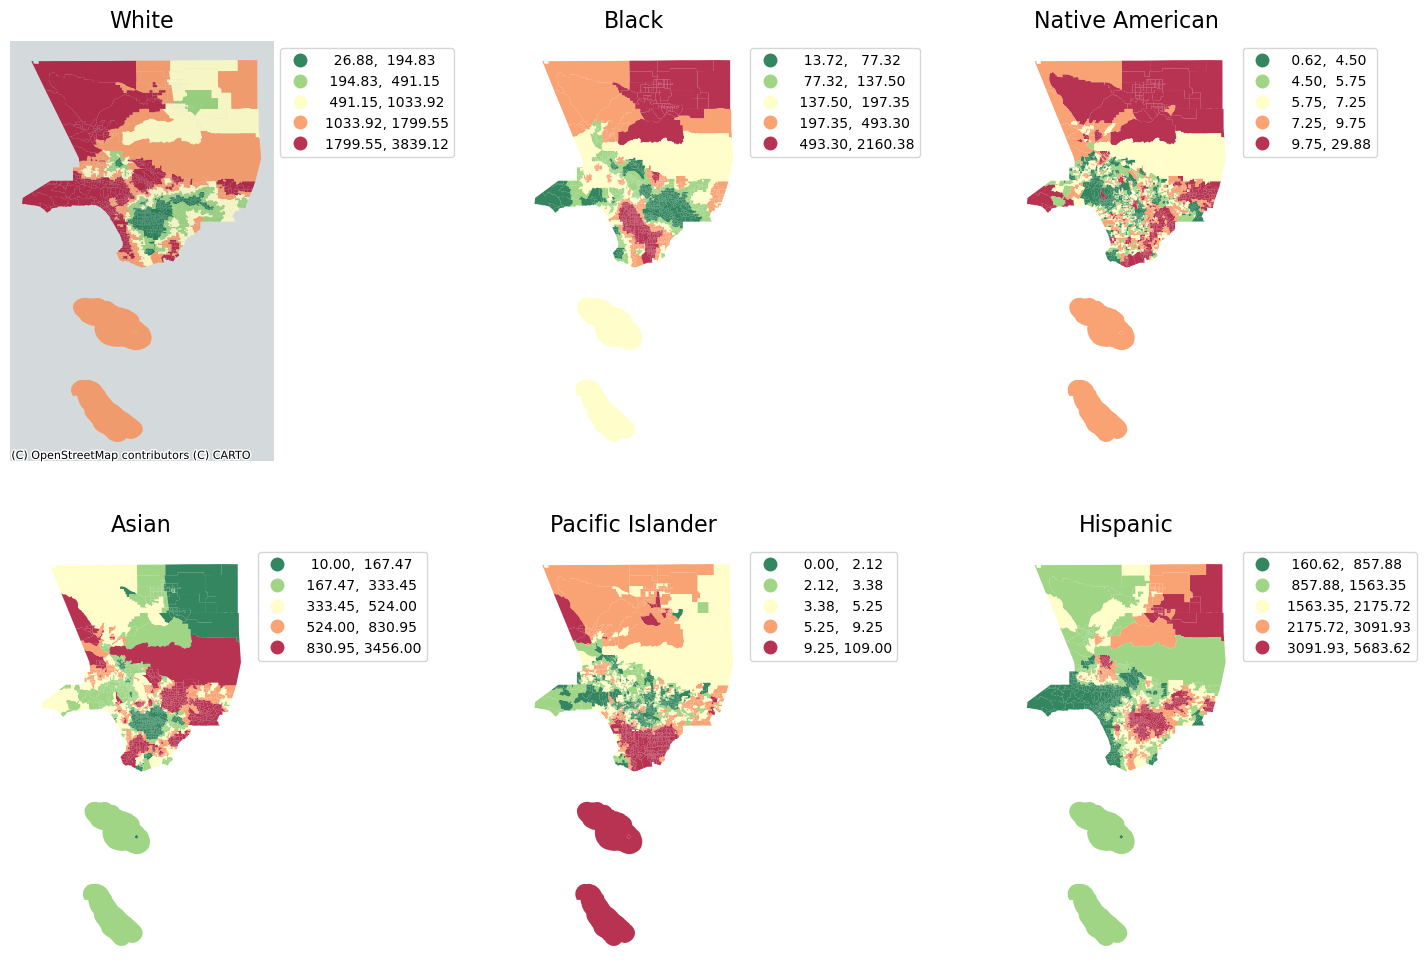

In [6]:
# Calculate spatial weight
wq = lps.weights.KNN.from_dataframe(tractsmerge, k=8)

# Row-standardization
wq.transform = 'r'

# Create a new column for the spatial lag for each race
for race in ['White', 'Black', 'Native American', 'Asian', 'Pacific Islander', 'Hispanic']:
    tractsmerge[race] = lps.weights.lag_spatial(wq, tractsmerge[race])

# Use subplots that make it easier to create multiple layered maps
fig, axs = plt.subplots(2, 3, figsize=(18, 12))
axs = axs.flatten()

# Spatial lag choropleth for each race
for i, race in enumerate(['White', 'Black', 'Native American', 'Asian', 'Pacific Islander', 'Hispanic']):
    tractsmerge.plot(ax=axs[i],
                      column=race,
                      legend=True,
                      alpha=0.8,
                      cmap='RdYlGn_r',
                      scheme='quantiles',
                      legend_kwds={'loc': 'upper left', 'bbox_to_anchor': (1, 1)})

    axs[i].axis('off')
    axs[i].set_title(race, fontsize=16, pad=10)

ctx.add_basemap(axs[0], source=ctx.providers.CartoDB.Positron)

# Now we can see the spatial distribution for all races except White
plt.show()

**Moran's Plot**

Quantifing the degree of the spatial correlation

In [15]:
# List of minority categories
minority_races = ['Black', 'Native American', 'Asian', 'Pacific Islander', 'Hispanic']

# Loop through each race group and calculate Moran's I
for race in minority_races:
    y = tractsmerge[race]
    moran = Moran(y, wq)
    print(f"Moran's I for {race}: {moran.I}")
 

Moran's I for Black: 0.9587063724775374
Moran's I for Native American: 0.781363465867272
Moran's I for Asian: 0.9223398588249941
Moran's I for Pacific Islander: 0.9116440680159332
Moran's I for Hispanic: 0.9319331410895783


**Moran's Plot**

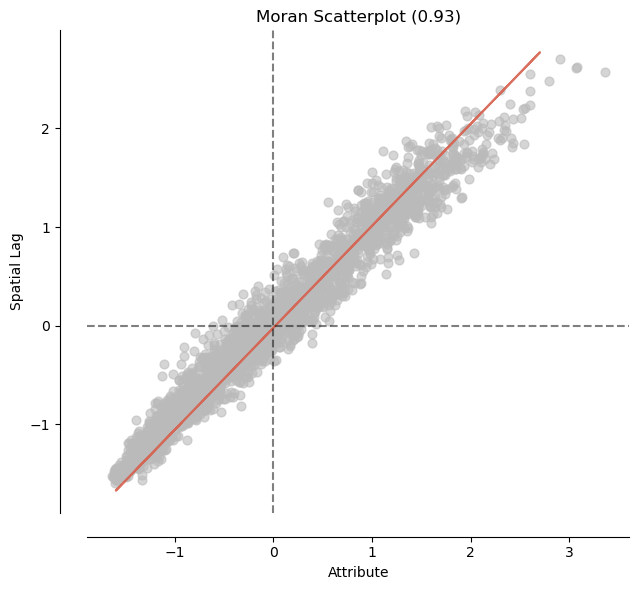

In [16]:
#creating scatter plot
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

/opt/conda/lib/python3.11/site-packages/splot/_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)


(<Figure size 700x700 with 1 Axes>,
 <Axes: title={'center': 'Reference Distribution'}, xlabel='Moran I: 0.93', ylabel='Density'>)

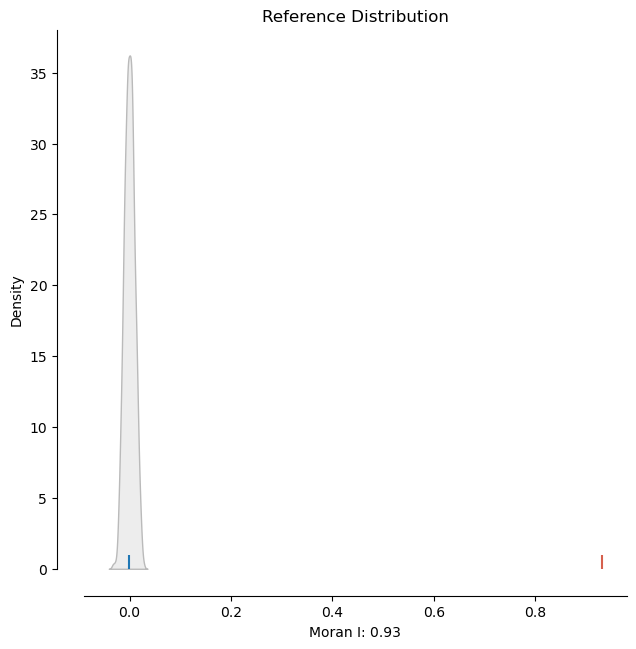

In [17]:
plot_moran_simulation(moran,aspect_equal=False)


The Moran I: 0.97 suggests a strong positive spatial autocorrelation, and indicates that values at nearby locations are highly similar, implying there is some form of spatial clustering or pattern.

In [18]:
#calculating empirical P-value 
moran.p_sim


0.001

The p-value of 0.001 indicates strong evidence against the null hypothesis that there is no spatial autocorrelation. Therefore, there is significant spatial autocorrelation.

**Moran Local Scatterplot**


In [19]:
# calculate local moran values
lisa = esda.moran.Moran_Local(y, wq)

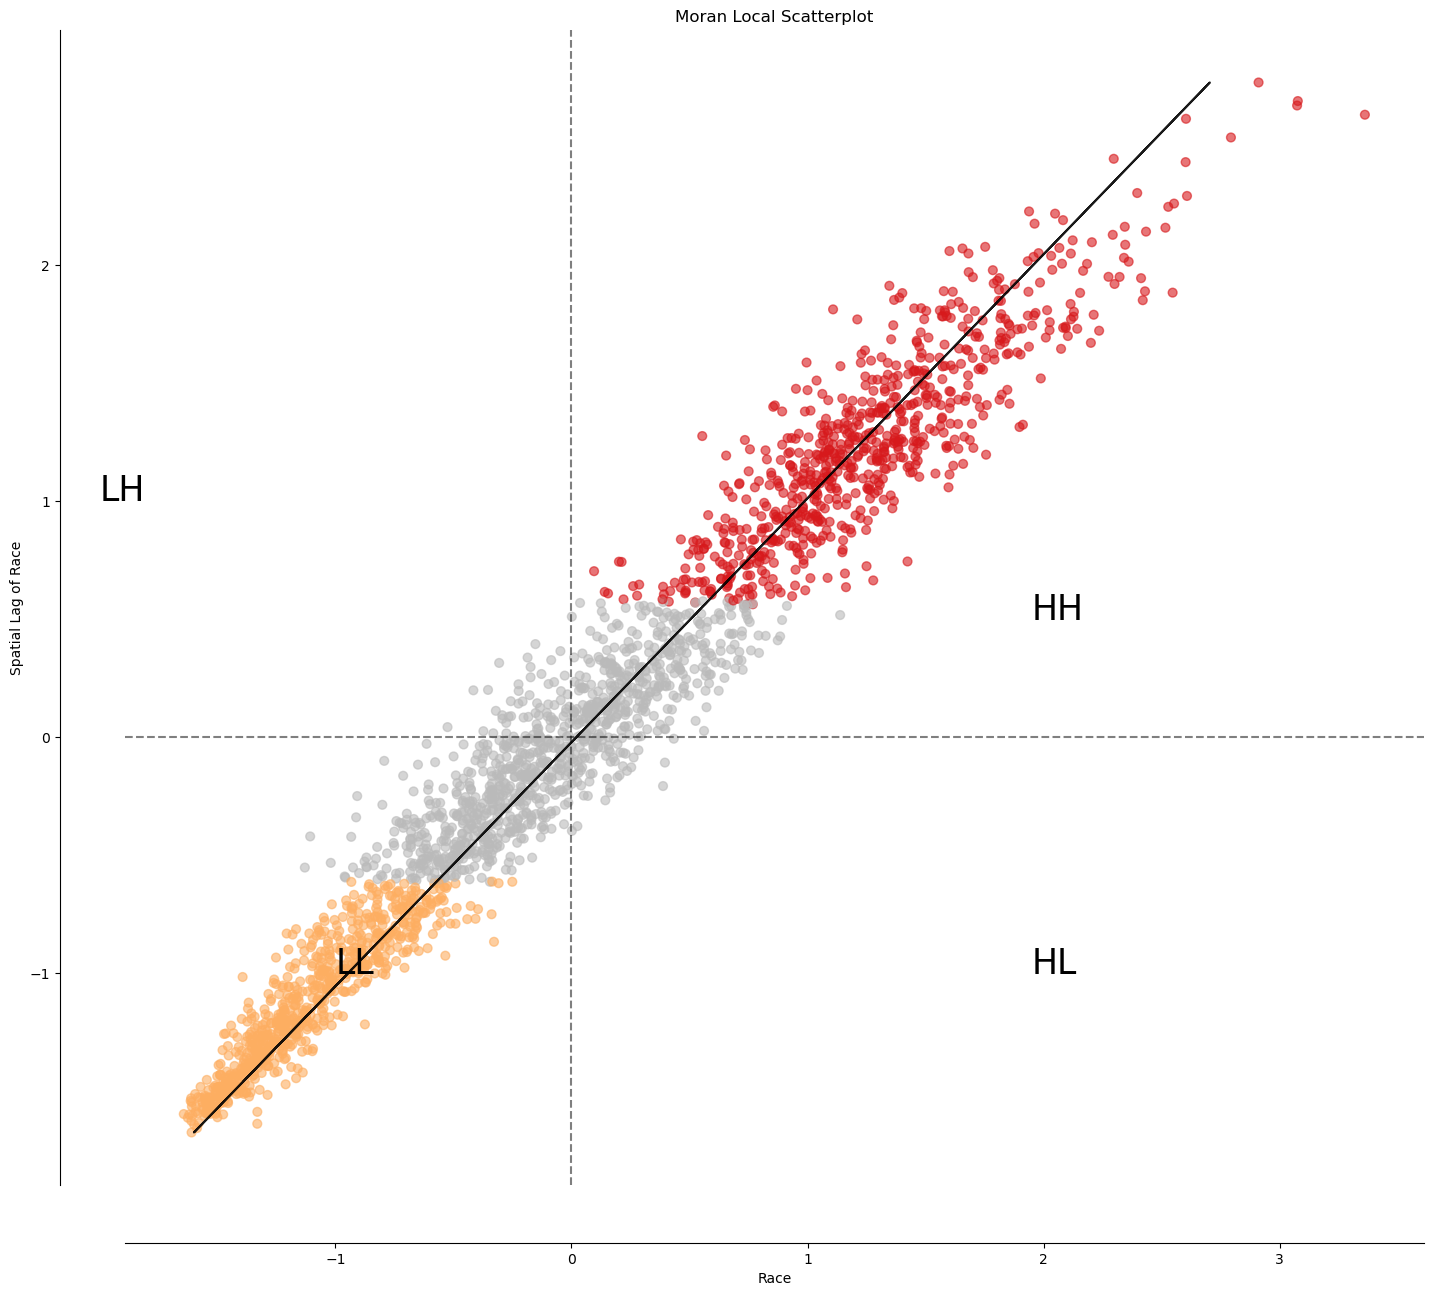

In [20]:
# plot
fig,ax = plt.subplots(figsize=(20,15))

moran_scatterplot(lisa, ax=ax, p=0.05)
ax.set_xlabel("Race")
ax.set_ylabel('Spatial Lag of Race')

# adding labels
plt.text(1.95, 0.5, "HH", fontsize=25) 
plt.text(1.95, -1, "HL", fontsize=25)
plt.text(-2, 1, "LH", fontsize=25)
plt.text(-1, -1, "LL", fontsize=25)
plt.show()


The colored dots represent the statisticaly significantly, spatially autocorrelated geographies.

**Spatial Autocorrelation Map**


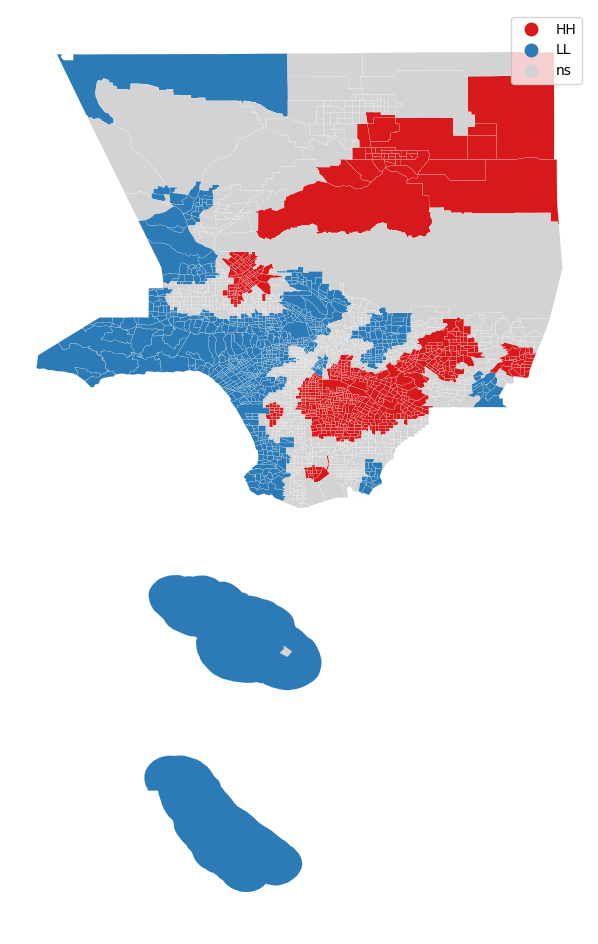

In [21]:
fig, ax = plt.subplots(figsize=(14,12))
lisa_cluster(lisa, tractsmerge, p=0.05, ax=ax)
plt.show()

HH clusters  indicate spatial areas where there is a concentration of high minority population in proximity to other areas with similarly high minority populations. These areas represent regions with significant minority communities or neighborhoods where minorities are spatially clustered. 

LL clusters  indicate spatial areas where there is a concentration of low minority population in proximity to other areas with similarly low minority population. These areas might represent regions where the minority population is relatively low or sparse.

**Group Member Contributions**

This notebook was complted by Pa-Shun to asses her assigned variable (racial demographics), and corresponds/connects to Yu and Aneesa's Spatial corelation notebooks. 